# **CRDM simulation and parameter recovery using QuestPlus**

- need to remove/fix everywhere using sum_axis or argmin with axis option.
- other default options (without axes and not approximating) are working though!
    - (which is needed for the online experiment!)
- ""*Array" in javascript is the same as *args in Python.


### Original Risk & Ambiguity Model (Gilboa & Schmeidler, 1989)
- Softmax Choice Model
- Gamma constant [1.5]

In [1]:
import numpy as np
import os
import os.path, sys
import pandas as pd
import pylab as plt
from scipy.stats import linregress, shapiro, spearmanr
import seaborn as sns
sns.set_theme(style = "white", palette = "muted")
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import time
np.seterr(all = "ignore") #disable numpy error prints in output
log = np.log ## assumes Euler's constant (2.71...) as base

base_proj_dir = "Z:/data/CCB" ## base project directory
save_dir = os.path.join(base_proj_dir, "derivatives/simulations/crdm/simulationQP") ## save directory for CRDM simulations
if not os.path.exists(save_dir): ## new Ss
    os.makedirs(save_dir) ## make new Ss save directory

def recur(params, *group):
    if len(params) == 0:
        return [group]   
    l = len(params[0])
    groups = []
    for x in range(l):
        groups.extend(recur(params[1:], *group, params[0][x]))
    return groups

def reformat_params(params):
    '''Gets every combination of parameters'''
    return recur(params)

Avg Number of Risk Trials Needed:       22 , SD: 0.0
Avg Number of Ambiguity Trials Needed:  42 , SD: 0.0

Spearman's Rho: 0.9835, Rho**2: 0.9672, p-value: 0.0000
Alpha Residual SD: 0.06546994139123109
Shapiro-Wilk: (0.9720997214317322, 8.634248135528603e-15)
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/simulationQP\simulationQP_model1_alpha_vAvBvG.png


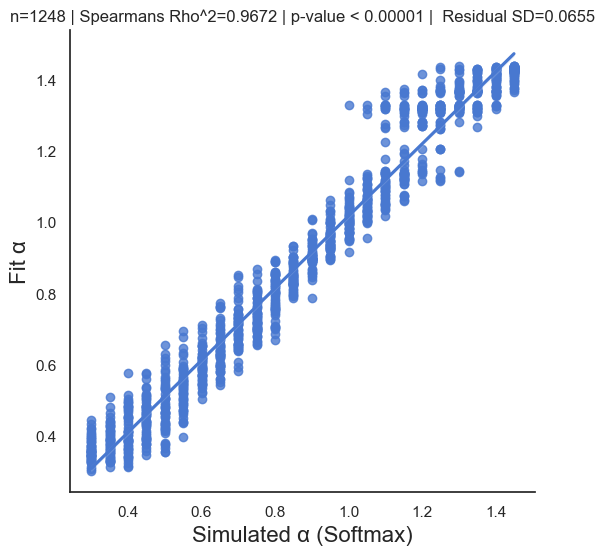

Spearman's Rho: 0.9597, Rho^2: 0.9211, p-value: 0.0000
Beta Residual SD: 0.2213684667896889
Shapiro-Wilk: (0.9777377247810364, 5.996052179074729e-13)
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/simulationQP\simulationQP_model1_beta_vAvBvG.png


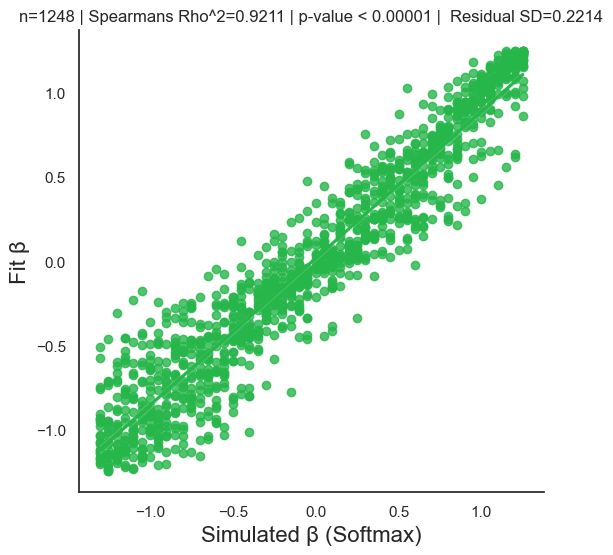

In [2]:
class QuestPlus:
    def __init__(self, stim, params, func):
        self.function     = func
        self.stim_domain  = stim
        self.param_domain = np.array(reformat_params(params))
        self._orig_params      = np.array(params)
        self._orig_param_shape = self._orig_params.shape
        self._orig_stim_shape  = self._orig_params.shape
        n_stim = self.stim_domain.shape[0]
        n_param = self.param_domain.shape[0]
        ## setup likelihoods for all combinations of stimuli and model parameter domains
        results = []
        for p in range(n_param):
            tmp  = self.param_domain[p]
            res  = func(self.stim_domain, tmp)
            results.append(res)
        results  = np.array(results)
        results  = results.T
        results2 = 1.0 - results
        z = np.zeros((*results.shape, 2))
        z[:, :, 0] = results
        z[:, :, 1] = results2
        self.likelihoods = z
        ## assume flat prior (init posterior to flat too)
        self.posterior = np.zeros(n_param) + 1.0 / n_param
        self.stim_history = []
        self.resp_history = []
        self.entropy      = np.ones(n_stim)

    def update(self, contrast_idx, ifcorrect):
        '''Update posterior probability with outcome of current trial.
            contrast  - contrast value for the given trial
            ifcorrect - whether response was correct or not (1 - correct, 0 - incorrect)
        '''
        ## turn ifcorrect to response index
        resp_idx = 1 - ifcorrect
        ## take likelihood of such resp for whole model parameter domain
        likelihood = self.likelihoods[contrast_idx].T[resp_idx]
        self.posterior *= likelihood
        self.posterior /= np.sum(self.posterior)
        ## log history of contrasts and responses
        self.stim_history.append(self.stim_domain[contrast_idx])
        self.resp_history.append(ifcorrect)
    
    def next_contrast(self):
        '''Get contrast value minimizing entropy of the posterior
            distribution.
            Expected entropy is updated in self.entropy
            Returns
            -------
            contrast : contrast value for the next trial
        '''
        ## full posterior needs to be i.e., shape [stims, parameter combinations, 2]
        ## posterior is assumed flat
        unormed_full_posterior = None
        summed0    = 0
        summed1    = 0
        nansummed0 = 0
        nansummed1 = 0
        entropy = None
        min_idx = 0
        min     = 9999
        ## use as few loops as possible to get necessary arrays
        posterior = self.posterior
        a = None
        b = None
        for i0, X0 in enumerate(self.likelihoods):
            ## sums need to be obtained ahead of time to normalize (+1 loop) 
            unormed_full_posterior = posterior.reshape(-1,1) * X0
            summed0 = np.sum(unormed_full_posterior[:, 0])
            summed1 = np.sum(unormed_full_posterior[:, 1])
            ## get log * normed, sums needed to norm, normed, and nansums of log products
            unormed_full_posterior[:, 0] /= summed0
            unormed_full_posterior[:, 1] /= summed1
            idx = np.where(unormed_full_posterior[:, 0] != 0)
            nansummed0 = np.nansum(unormed_full_posterior[:, 0][idx] * np.log(unormed_full_posterior[:, 0][idx]))
            idx = np.where(unormed_full_posterior[:, 1] != 0)
            nansummed1 = np.nansum(unormed_full_posterior[:, 1][idx] * np.log(unormed_full_posterior[:, 1][idx]))
            entropy = -nansummed0 * summed0 -nansummed1 * summed1
            if (entropy < min):
                min = entropy
                min_idx = i0
        return min_idx
    
    def get_posterior(self):
        return self.posterior.reshape(self._orig_param_shape)

    def get_fit_params(self, method = "mean"):
        if method == 'max':
            return self.param_domain[np.argmax(self.posterior)]
        ## mean weighted
        weights = self.posterior.reshape(-1, 1)
        while weights.shape[-1] != self.param_domain.shape[-1]:
            weights = np.hstack((weights, self.posterior.reshape(-1, 1)))
        return np.average(self.param_domain, weights=weights, axis=0)
    
if __name__ == "__main__":
    def draw_from(stimulus_value, params, func):
        prob = func(stimulus_value, params)
        if (np.random.random() < prob):
            return 1
        return 0
        
    def subjective_prob(p, amb, beta):
        if np.isscalar(amb):
            if amb == 0:
                return p
            return amb*(p+beta)
        obj_idx = np.where(amb == 0)
        p_s = amb * (p + beta)
        p_s[obj_idx] = p[obj_idx]
        return p_s

    def SVs(alpha, beta, lottery, certain_value, ambiguity, probability):
        ''' uses original SV formula from Gilboa & Schmeidler, 1989 '''
        sv_lott = (probability - beta * ambiguity / 2) * lottery**alpha 
        sv_safe = certain_value**alpha
        return sv_lott, sv_safe

    def probability_of_lottery_choice(stimulus_values, params):
        '''gamma function'''
        lottery_value, ambiguity, probability, certain_value = stimulus_values[0], stimulus_values[1], stimulus_values[2], stimulus_values[3]
        if len(stimulus_values.shape) > 1:
            tmp = stimulus_values.T
            lottery_value, ambiguity, probability,certain_value = tmp[0], tmp[1], tmp[2], tmp[3]
        alpha = 0
        beta  = 0
        gamma = 0
        if len(params) == 2:
            alpha, gamma = params
        else:
            alpha, beta, gamma = params
        SV_lottery, SV_certain = SVs(alpha, beta, lottery_value, certain_value, ambiguity, probability)
        return 1 / (1 + np.exp(-gamma * (SV_lottery - SV_certain)))
    
    def arange_round(start, end, step=1, round=2):
        return np.round(np.arange(start, end, step), round)
    

    value_space = [8, 20, 40, 50]
    ambiguity_space   = np.array([0.24,  0.5, 0.74])
    probability_space = np.array([0.13, 0.25, 0.38, 0.50, 0.75])
    value_certain = 5
    stim_spaceA = []
    
    for v in value_space: 
        for p in probability_space:
            stim_spaceA.append([v, 0, p, value_certain])
    stim_spaceA = np.array(stim_spaceA)

    '''
    # participant parameter space 
    # alpha
    # - above one is risk seeking
    # - below 1 is risk averse
    # must be nonzero (unless they value nothing)
    '''

    ## original formula parameter space
    alpha_space = np.round(np.arange(0.3, 1.5, .05), 2)
    beta_space = np.round(np.arange(-1.3, 1.3, .05), 2)
    gamma_space = np.round(np.arange(0.5, 8, 7.5/alpha_space.shape[0]), 2) # gamma needs to be same space size as alpha
    ## param spaces need to be the same size
    paramsA = [alpha_space, gamma_space]
    recovered_alphas = []
    alpha_x = []
    recovered_betas = []
    trials_alpha = []
    trials_beta = []
    accepted_error = 0.1

    for p_gamma in [1.5]: ## gamma_space:
        for p_alpha in alpha_space:
            for p_beta in beta_space:
                contrast_idx = None
                #response = True
                response = None
                ## uses contrast_idx instead of contrast for speed reasons
                ## doesn't ever estimate the contrast
                contrast_idx = stim_spaceA.shape[0]//2
                ## alpha/gamma
                true_params = [p_alpha, p_gamma]
                q = QuestPlus(stim_spaceA, paramsA, probability_of_lottery_choice)
                ## go through trials
                upper_limit = 200
                i = 0
                while i < 22:
                    t0 = time.time()
                    ## update posterior
                    ## lottery, alpha, beta, certain_value, ambiguity, probability
                    response = draw_from(stim_spaceA[contrast_idx], true_params, probability_of_lottery_choice)
                    q.update(contrast_idx, response)
                    ## find next contrast index
                    contrast_idx=q.next_contrast()
                    t1 = time.time()
                    i+=1
                trials_alpha.append(i)
                fit = q.get_fit_params()
                alpha = fit[0]
                gamma = fit[1]
                recovered_alphas.append(alpha)
                alpha_x.append(p_alpha)
                ## using fitted alpha, get beta
                paramsB = [np.array([alpha] * beta_space.shape[0]), beta_space, [gamma] * beta_space.shape[0]]
                stim_spaceB = []
                ## use ambiguity trials
                for v in value_space:
                    for a in ambiguity_space:
                        stim_spaceB.append([v, a, 0.5, value_certain])
                stim_spaceB = np.array(stim_spaceB)
                contrast_idx = stim_spaceA.shape[0]//2
                true_params = [p_alpha, p_beta, p_gamma] ## alpha/beta/gamma
                q = QuestPlus(stim_spaceB, paramsB, probability_of_lottery_choice)
                ## go through trials
                i = 0
                while i < 42:
                    t0 = time.time()
                    ## update posterior
                    ## lottery, alpha, beta, certain_value, ambiguity, probability
                    response = draw_from(stim_spaceB[contrast_idx], true_params, probability_of_lottery_choice)
                    q.update(contrast_idx, response)
                    contrast_idx = q.next_contrast() ## find next contrast index
                    t1 = time.time()
                    i += 1
                trials_beta.append(i)
                fit = q.get_fit_params()
                #print("Alpha, Beta, Gamma\n{0:.2f} {1:.2f} {2:.2f}".format(*q.get_fit_params()))
                recovered_betas.append(fit[1])
                #print("True Alpha, Beta, Gamma\n{0:.2f} {1:.2f} {2:.2f}\n".format(p_alpha, p_beta, p_gamma))

    print("Avg Number of Risk Trials Needed:      ", int(np.mean(trials_alpha)), ", SD:", np.std(trials_alpha))
    print("Avg Number of Ambiguity Trials Needed: ",  int(np.mean(trials_beta)), ", SD:", np.std(trials_beta))
    print("")

    df = pd.DataFrame()

    ## plot alpha fit
    rho, pvalue = spearmanr(alpha_x, recovered_alphas)
    print("Spearman's Rho: {0:0.4f}, Rho**2: {1:0.4f}, p-value: {2:0.4f}".format(rho, rho**2, pvalue))
    ## not applicable as statistical test because assumptions are violated for heteroscedasticity, but needed to check assumption
    result = linregress(alpha_x, recovered_alphas)
    #print(result.rvalue, result.pvalue)
    line_y = np.array(alpha_x) * result.slope + result.intercept
    residuals = np.array(alpha_x) - np.array(recovered_alphas)
    ## SD of 0.3 means half the data is in a range of 0.6 around mean value, which is ~1/4 of beta's range
    print("Alpha Residual SD:", np.std(residuals))
    print("Shapiro-Wilk:", shapiro(residuals)[:]) ## violates heteroscedasticity if significant
    df["Simulated α (Softmax)"] = alpha_x
    df["Fit α"] = recovered_alphas
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.regplot(x = "Simulated α (Softmax)", y = "Fit α", data = df)
    sns.despine(top = True)
    ax.set_ylabel("Fit α", fontsize=16)
    ax.set_xlabel("Simulated α (Softmax)", fontsize=16)
    plt.title("n={3} | Spearmans Rho^2={0:.4f} | p-value < {1:.4f}1 |  Residual SD={2:.4f}".format(rho**2, 
                                                                                                    pvalue, 
                                                                                                    np.std(residuals), 
                                                                                                    len(alpha_x)))
    fig_name1 = os.path.join(save_dir, "simulationQP_model1_alpha_vAvBcG.png")
    print("Saving to: {}".format(fig_name1))
    plt.savefig(fig_name1)
    plt.show()

    ##plot beta fit
    beta_x = beta_space.tolist() * alpha_space.shape[0]
    rho, pvalue = spearmanr(beta_x, recovered_betas)
    print("Spearman's Rho: {0:0.4f}, Rho^2: {1:0.4f}, p-value: {2:0.4f}".format(rho, rho**2, pvalue))
    ## not applicable as statistical test because assumptions are violated for heteroscedasticity, but needed to check assumption
    result = linregress(beta_x, recovered_betas)
    #print(result.rvalue, result.pvalue)
    line_y = np.array(beta_x) * result.slope + result.intercept
    residuals = np.array(beta_x) - np.array(recovered_betas)
    ## SD of 0.3 means half the data is in a range of 0.6 around mean value, which is ~1/4 of beta's range
    print("Beta Residual SD:", np.std(residuals))
    print("Shapiro-Wilk:", shapiro(residuals)[:]) ## violates heteroscedasticity if significant
    df["Simulated β (Softmax)"] = beta_x
    df["Fit β"] = recovered_betas
    fig, ax2 = plt.subplots(figsize=(6, 6))
    ax2 = sns.regplot(x = "Simulated β (Softmax)", y = "Fit β", data = df, color = "#26B64A")
    sns.despine(top = True)
    ax2.set_ylabel("Fit β", fontsize=16)
    ax2.set_xlabel("Simulated β (Softmax)", fontsize=16)
    plt.title("n={3} | Spearmans Rho^2={0:.4f} | p-value < {1:.4f}1 |  Residual SD={2:.4f}".format(rho**2, 
                                                                                                    pvalue, 
                                                                                                    np.std(residuals), 
                                                                                                    len(beta_x)))
    fig_name2 = os.path.join(save_dir, "simulationQP_model1_beta_vAvBcG.png")
    print("Saving to: {}".format(fig_name2))
    plt.savefig(fig_name2)
    plt.show()


### Reformulated Risk & Ambiguity Model
- Softmax Choice Model
- Gamma constant [1.5]

Avg Number of Risk Trials Needed:       22 , SD: 0.0
Avg Number of Ambiguity Trials Needed:  42 , SD: 0.0

Spearman's Rho: 0.9849, Rho**2: 0.9701, p-value: 0.0000
Alpha Residual SD: 0.0705184669593712
Shapiro-Wilk: (0.9783955216407776, 7.959486225672663e-08)
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/simulationQP\simulationQP_model2_alpha_vAvBvG.png


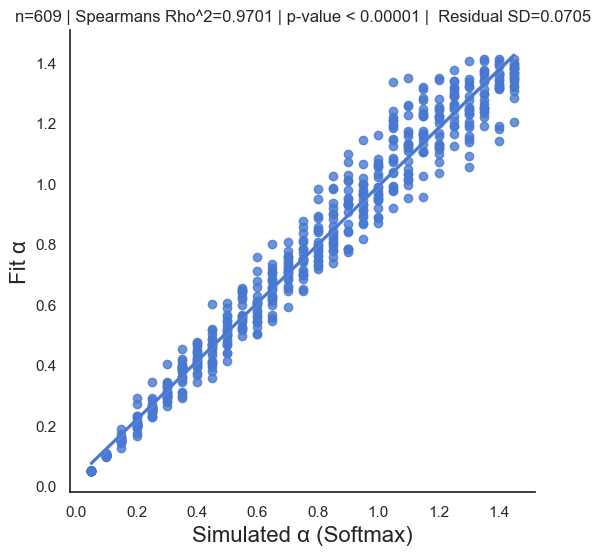

Spearman's Rho: 0.9729, Rho^2: 0.9466, p-value: 0.0000
Beta Residual SD: 0.06989377277152826
Shapiro-Wilk: (0.956521213054657, 1.9944196034266115e-12)
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/simulationQP\simulationQP_model2_beta_vAvBvG.png


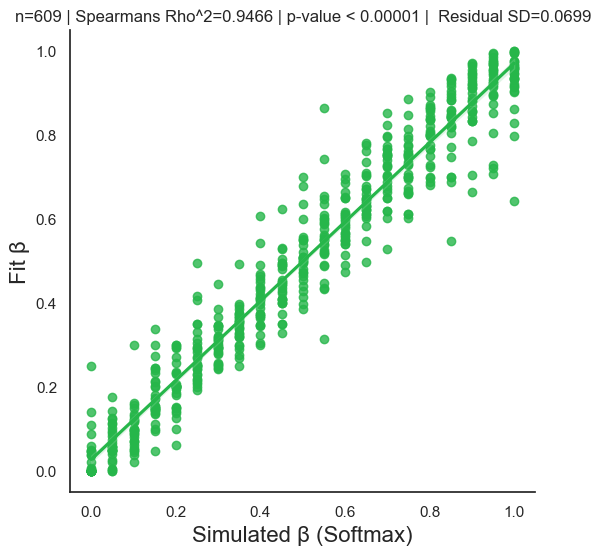

In [15]:
class QuestPlus:
    def __init__(self, stim, params, func):
        self.function     = func
        self.stim_domain  = stim
        self.param_domain = np.array(reformat_params(params))
        self._orig_params      = np.array(params)
        self._orig_param_shape = self._orig_params.shape
        self._orig_stim_shape  = self._orig_params.shape
        n_stim = self.stim_domain.shape[0]
        n_param = self.param_domain.shape[0]
        ## setup likelihoods for all combinations of stimuli and model parameter domains
        results = []
        for p in range(n_param):
            tmp  = self.param_domain[p]
            res  = func(self.stim_domain, tmp)
            results.append(res)
        results  = np.array(results)
        results  = results.T
        results2 = 1.0 - results
        z = np.zeros((*results.shape, 2))
        z[:, :, 0] = results
        z[:, :, 1] = results2
        self.likelihoods = z
        ## assume a flat prior (init posterior to flat too)
        self.posterior = np.zeros(n_param) + 1.0 / n_param
        self.stim_history = []
        self.resp_history = []
        self.entropy      = np.ones(n_stim)

    def update(self, contrast_idx, ifcorrect):
        '''Update posterior probability with outcome of current trial.
            contrast  - contrast value for given trial
            ifcorrect - whether response was correct or not (1 - correct, 0 - incorrect)
        '''
        ## turn ifcorrect to response index
        resp_idx = 1 - ifcorrect
        ## take likelihood of such resp for whole model parameter domain
        likelihood = self.likelihoods[contrast_idx].T[resp_idx]
        self.posterior *= likelihood
        self.posterior /= np.sum(self.posterior)
        ## log history of contrasts and responses
        self.stim_history.append(self.stim_domain[contrast_idx])
        self.resp_history.append(ifcorrect)
    
    def next_contrast(self):
        '''Get contrast value minimizing entropy of the posterior
            distribution.
            Expected entropy is updated in self.entropy
            Returns
            -------
            contrast : contrast value for the next trial
        '''
        ## full posterior needs to be i.e., shape [stims, parameter combinations, 2]
        ## posterior is assumed flat
        unormed_full_posterior = None
        summed0    = 0
        summed1    = 0
        nansummed0 = 0
        nansummed1 = 0
        entropy = None
        min_idx = 0
        min     = 9999
        ## use as few loops as possible to get necessary arrays
        posterior = self.posterior
        a = None
        b = None
        for i0, X0 in enumerate(self.likelihoods):
            ## sums need to be obtained ahead of time to normalize (+1 loop) 
            unormed_full_posterior = posterior.reshape(-1,1) * X0
            summed0 = np.sum(unormed_full_posterior[:, 0])
            summed1 = np.sum(unormed_full_posterior[:, 1])
            ## get log * normed, sums needed to norm, normed, and nansums of log products
            unormed_full_posterior[:, 0] /= summed0
            unormed_full_posterior[:, 1] /= summed1
            idx = np.where(unormed_full_posterior[:, 0] != 0)
            nansummed0 = np.nansum(unormed_full_posterior[:, 0][idx] * np.log(unormed_full_posterior[:, 0][idx]))
            idx = np.where(unormed_full_posterior[:, 1] != 0)
            nansummed1 = np.nansum(unormed_full_posterior[:, 1][idx] * np.log(unormed_full_posterior[:, 1][idx]))
            entropy = -nansummed0 * summed0 -nansummed1 * summed1
            if (entropy < min):
                min = entropy
                min_idx = i0
        ## choose contrast idx with minimal entropy
        return min_idx
    
    def get_posterior(self):
        return self.posterior.reshape(self._orig_param_shape)

    def get_fit_params(self, method = "mean"):
        if method == 'max':
            return self.param_domain[np.argmax(self.posterior)]
        ## mean weighted
        weights = self.posterior.reshape(-1, 1)
        while weights.shape[-1] != self.param_domain.shape[-1]:
            weights = np.hstack((weights, self.posterior.reshape(-1, 1)))
        return np.average(self.param_domain, weights=weights, axis=0)
    
if __name__ == "__main__":
    def draw_from(stimulus_value, params, func):
        prob = func(stimulus_value, params)
        if (np.random.random() < prob):
            return 1
        return 0
        
    def subjective_prob(p, amb, beta):
        ## beta [0, 1]
        ## amb  [0, 1] 
        if np.isscalar(amb):
            if amb == 0:
                return p
            return amb*(p+beta)
        obj_idx = np.where(amb == 0)
        p_s = amb * (p + beta)
        p_s[obj_idx] = p[obj_idx]
        return p_s

    def SVs(alpha, beta, lottery, certain_value, ambiguity, probability):
        p_s = subjective_prob(probability, ambiguity, beta)
        sv_lott = p_s * lottery * alpha**(1 - p_s)
        sv_safe = certain_value ## $5
        return sv_lott, sv_safe
    
    def probability_of_lottery_choice(stimulus_values, params):
        '''gamma function'''
        lottery_value, ambiguity, probability, certain_value = stimulus_values[0], stimulus_values[1], stimulus_values[2], stimulus_values[3]
        if len(stimulus_values.shape) > 1:
            tmp = stimulus_values.T
            lottery_value, ambiguity, probability,certain_value = tmp[0], tmp[1], tmp[2], tmp[3]
        alpha = 0
        beta  = 0
        gamma = 0
        if len(params) == 2:
            alpha, gamma = params
        else:
            alpha, beta, gamma = params
        SV_lottery, SV_certain = SVs(alpha, beta, lottery_value, certain_value, ambiguity, probability)
        return 1 / (1 + np.exp(-gamma * (SV_lottery - SV_certain)))
    
    def arange_round(start, end, step=1, round=2):
        return np.round(np.arange(start, end, step), round)
    
    
    value_space = [8, 20, 40, 50]
    ambiguity_space   = np.array([0.24,  0.5, 0.74])
    probability_space = np.array([0.13, 0.25, 0.38, 0.50, 0.75])
    value_certain = 5
    stim_spaceA = []
    
    for v in value_space: 
        for p in probability_space:
            stim_spaceA.append([v, 0, p, value_certain])
    stim_spaceA = np.array(stim_spaceA)

    ## new formula space
    alpha_space = np.round(np.arange(0.05,  1.5, .05), 2)
    beta_space  = np.round(np.arange( 0.0, 1.01, .05), 2)

    ## gamma needs to be same space size as alpha
    gamma_space = np.round(np.arange(0.5, 8, 7.5 / alpha_space.shape[0]), 2)

    ## each of the param spaces need to be the same size
    paramsA = [alpha_space, gamma_space]
    recovered_alphas = []
    alpha_x = []
    recovered_betas = []
    trials_alpha = []
    trials_beta = []
    accepted_error = 0.1

    for p_gamma in [1.5]: ## gamma_space:
        for p_alpha in alpha_space:
            for p_beta in beta_space:
                contrast_idx = None
                #response = True
                response = None
                ## uses contrast_idx instead of contrast for speed reasons
                ## doesn't ever estimate the contrast
                contrast_idx = stim_spaceA.shape[0]//2
                ## alpha/gamma
                true_params = [p_alpha, p_gamma]
                q = QuestPlus(stim_spaceA, paramsA, probability_of_lottery_choice)
                ## go through trials
                upper_limit = 200
                i = 0
                while i < 22:
                    t0 = time.time()
                    ## update posterior
                    ## lottery, alpha, beta, certain_value, ambiguity, probability
                    response = draw_from(stim_spaceA[contrast_idx], true_params, probability_of_lottery_choice)
                    q.update(contrast_idx, response)
                    ## find next contrast index
                    contrast_idx=q.next_contrast()
                    t1 = time.time()
                    i+=1
                trials_alpha.append(i)
                fit = q.get_fit_params()
                alpha = fit[0]
                gamma = fit[1]
                recovered_alphas.append(alpha)
                alpha_x.append(p_alpha)

                ## using fitted alpha, get beta
                paramsB = [np.array([alpha] * beta_space.shape[0]), beta_space, [gamma] * beta_space.shape[0]]
                stim_spaceB = []
                ## use ambiguity trials
                for v in value_space:
                    for a in ambiguity_space:
                        stim_spaceB.append([v, a, 0.5, value_certain])
                stim_spaceB = np.array(stim_spaceB)
                contrast_idx = stim_spaceA.shape[0]//2
                true_params = [p_alpha, p_beta, p_gamma] ## alpha/beta/gamma
                q = QuestPlus(stim_spaceB, paramsB, probability_of_lottery_choice)
                ## go through trials
                i = 0
                while i < 42:
                    t0 = time.time()
                    ## update posterior
                    ## lottery, alpha, beta, certain_value, ambiguity, probability
                    response = draw_from(stim_spaceB[contrast_idx], true_params, probability_of_lottery_choice)
                    q.update(contrast_idx, response)
                    contrast_idx = q.next_contrast() ## find next contrast index
                    t1 = time.time()
                    i += 1
                trials_beta.append(i)
                fit = q.get_fit_params()
                #print("Alpha, Beta, Gamma\n{0:.2f} {1:.2f} {2:.2f}".format(*q.get_fit_params()))
                recovered_betas.append(fit[1])
                #print("True Alpha, Beta, Gamma\n{0:.2f} {1:.2f} {2:.2f}\n".format(p_alpha, p_beta, p_gamma))

    print("Avg Number of Risk Trials Needed:      ", int(np.mean(trials_alpha)), ", SD:", np.std(trials_alpha))
    print("Avg Number of Ambiguity Trials Needed: ",  int(np.mean(trials_beta)), ", SD:", np.std(trials_beta))
    print("")
    
    df = pd.DataFrame()

    ## plot alpha fit
    rho, pvalue = spearmanr(alpha_x, recovered_alphas)
    print("Spearman's Rho: {0:0.4f}, Rho**2: {1:0.4f}, p-value: {2:0.4f}".format(rho, rho**2, pvalue))
    ## not applicable as statistical test because assumptions are violated for heteroscedasticity, but needed to check assumption
    result = linregress(alpha_x, recovered_alphas)
    #print(result.rvalue, result.pvalue)
    line_y = np.array(alpha_x) * result.slope + result.intercept
    residuals = np.array(alpha_x) - np.array(recovered_alphas)
    ## SD of 0.3 means half the data is in a range of 0.6 around mean value, which is ~1/4 of beta's range
    print("Alpha Residual SD:", np.std(residuals))
    print("Shapiro-Wilk:", shapiro(residuals)[:]) ## violates heteroscedasticity if significant
    df["Simulated α (Softmax)"] = alpha_x
    df["Fit α"] = recovered_alphas
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.regplot(x = "Simulated α (Softmax)", y = "Fit α", data = df)
    sns.despine(top = True)
    ax.set_ylabel("Fit α", fontsize=16)
    ax.set_xlabel("Simulated α (Softmax)", fontsize=16)
    plt.title("n={3} | Spearmans Rho^2={0:.4f} | p-value < {1:.4f}1 |  Residual SD={2:.4f}".format(rho**2, 
                                                                                                    pvalue, 
                                                                                                    np.std(residuals), 
                                                                                                    len(alpha_x)))
    fig_name1 = os.path.join(save_dir, "simulationQP_model2_alpha_vAvBcG.png")
    print("Saving to: {}".format(fig_name1))
    plt.savefig(fig_name1)
    plt.show()

    ##plot beta fit
    beta_x = beta_space.tolist() * alpha_space.shape[0]
    rho, pvalue = spearmanr(beta_x, recovered_betas)
    print("Spearman's Rho: {0:0.4f}, Rho^2: {1:0.4f}, p-value: {2:0.4f}".format(rho, rho**2, pvalue))
    ## not applicable as statistical test because assumptions are violated for heteroscedasticity, but needed to check assumption
    result = linregress(beta_x, recovered_betas)
    #print(result.rvalue, result.pvalue)
    line_y = np.array(beta_x) * result.slope + result.intercept
    residuals = np.array(beta_x) - np.array(recovered_betas)
    ## SD of 0.3 means half the data is in a range of 0.6 around mean value, which is ~1/4 of beta's range
    print("Beta Residual SD:", np.std(residuals))
    print("Shapiro-Wilk:", shapiro(residuals)[:]) ## violates heteroscedasticity if significant
    df["Simulated β (Softmax)"] = beta_x
    df["Fit β"] = recovered_betas
    fig, ax2 = plt.subplots(figsize=(6, 6))
    ax2 = sns.regplot(x = "Simulated β (Softmax)", y = "Fit β", data = df, color = "#26B64A")
    sns.despine(top = True)
    ax2.set_ylabel("Fit β", fontsize=16)
    ax2.set_xlabel("Simulated β (Softmax)", fontsize=16)
    plt.title("n={3} | Spearmans Rho^2={0:.4f} | p-value < {1:.4f}1 |  Residual SD={2:.4f}".format(rho**2, 
                                                                                                    pvalue, 
                                                                                                    np.std(residuals), 
                                                                                                    len(beta_x)))
    fig_name2 = os.path.join(save_dir, "simulationQP_model2_beta_vAvBcG.png")
    print("Saving to: {}".format(fig_name2))
    plt.savefig(fig_name2)
    plt.show()

In [ ]:
import numpy as np
from scipy.stats import bernoulli

MLL_trials = np.array([2.0, 1.0, 1.0]) ## each value represents the sum of lottery choices in that condition subgroup | number of trials per subgroup = 2
MLL_probs  = np.array([1.0, 0.5, 0.7]) ## probability (predictive - not proportion) Ss will chose lottery for each condition subgroup
MLL_total_trials = np.array([2, 2, 2]) ## number of trials per subgroup
print("No black box LL:    ", np.nansum(np.log(MLL_probs) * MLL_trials + np.log(1 - MLL_probs) * (MLL_total_trials - MLL_trials)))

BLL_trials = np.array([1.0, 1.0, 0.0, 1.0, 1.0, 0.0])
BLL_probs  = np.array([1.0, 1.0, 0.5, 0.5, 0.7, 0.7])
print("Bernoulli logpmf LL:", np.nansum(bernoulli.logpmf(BLL_trials, BLL_probs)))

No black box LL:     -2.946942109384559
Bernoulli logpmf LL: -2.946942109384559
